#  DENOISING AUTOENCODER

AUTHOR: [ARIHARASUDHAN](http://arihara-sudhan.github.io)      
DATE: 19/10/2024




> Guys, This is an experiment of removing a black spot using supervised training...

**MAKING A DATASET**

In [140]:
import os
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, clean_folder, masked_folder, transform=None):
        self.clean_folder = clean_folder
        self.masked_folder = masked_folder
        self.transform = transform
        self.clean_images = sorted(os.listdir(clean_folder))
    
    def __len__(self):
        return len(self.clean_images)
    
    def __getitem__(self, idx):
        clean_image_name = self.clean_images[idx]
        clean_image_path = os.path.join(self.clean_folder, clean_image_name)
        clean_image = Image.open(clean_image_path)
        mask_prefix = clean_image_name.split('.')[0]
        mask_candidates = [mask for mask in os.listdir(self.masked_folder) if f"-{mask_prefix}." in mask]
        selected_mask_name = random.choice(mask_candidates)
        selected_mask_path = os.path.join(self.masked_folder, selected_mask_name)
        mask_image = Image.open(selected_mask_path)
        if self.transform:
            clean_image = self.transform(clean_image)
            mask_image = self.transform(mask_image)
        return clean_image, mask_image

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
clean_images_folder = "/kaggle/input/masked-denoiser/MASKED/clean"
masked_images_folder = "/kaggle/input/masked-denoiser/MASKED/masked"
dataset = MyDataset(clean_images_folder, masked_images_folder, transform=transform)

In [141]:
from torch.utils.data import DataLoader
batch_size = 8
dataset = MyDataset(clean_images_folder, masked_images_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [142]:
for i in dataloader:
    break

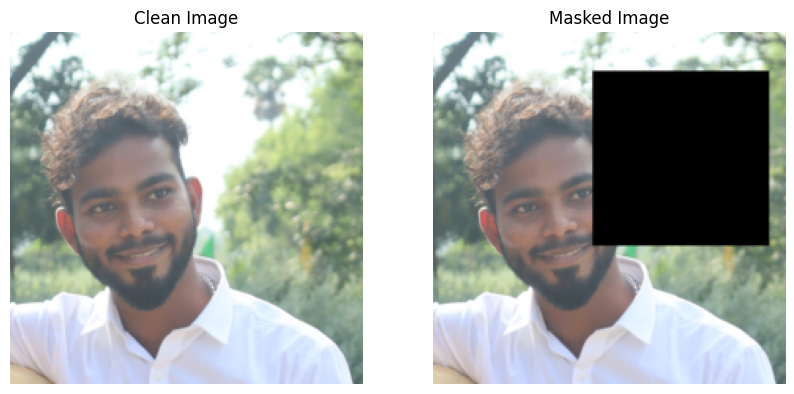

In [113]:
import matplotlib.pyplot as plt

dataset = MyDataset(clean_images_folder, masked_images_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
clean_image, mask_image = next(iter(dataloader))
clean_image_np = clean_image[0].permute(1, 2, 0).numpy()
mask_image_np = mask_image[0].permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(clean_image_np)
plt.title('Clean Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask_image_np)
plt.title('Masked Image')
plt.axis('off')
plt.show()


**MODEL ARCHITECTURE**

In [154]:
import torch.nn as nn
import torch.nn.functional as F

class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        
        # First block: input --> 64 filters
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second block: 64 filters --> 128 filters
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Third block: 128 filters --> 256 filters
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # Pooling and dropout layer for regularization
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Deconv block: 256 --> 128 filters
        self.t_conv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.t_bn1 = nn.BatchNorm2d(128)
        self.t_conv2 = nn.ConvTranspose2d(128, 128, 3, padding=1)
        self.t_bn2 = nn.BatchNorm2d(128)

        # Deconv block: 128 --> 64 filters
        self.t_conv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.t_bn3 = nn.BatchNorm2d(64)
        self.t_conv4 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.t_bn4 = nn.BatchNorm2d(64)
        
        # Deconv block: 64 --> 32 filters
        self.t_conv5 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_bn5 = nn.BatchNorm2d(32)
        
        # Final conv layer: 32 --> 1 (output depth)
        self.conv_out = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x):
        # First block
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = self.pool(x1)
        x1 = self.dropout(x1)
        
        # Second block
        x2 = F.relu(self.bn3(self.conv3(x1)))
        x2 = F.relu(self.bn4(self.conv4(x2)))
        x2 = self.pool(x2)
        x2 = self.dropout(x2)
        
        # Third block
        x3 = F.relu(self.bn5(self.conv5(x2)))
        x3 = F.relu(self.bn6(self.conv6(x3)))
        x3 = self.pool(x3)
        x3 = self.dropout(x3)
        
        # First deconv block
        x = F.relu(self.t_bn1(self.t_conv1(x3)))
        x = F.relu(self.t_bn2(self.t_conv2(x)))
        
        # Second deconv block
        x = F.relu(self.t_bn3(self.t_conv3(x)))
        x = F.relu(self.t_bn4(self.t_conv4(x)))
        
        # Third deconv block
        x = F.relu(self.t_bn5(self.t_conv5(x)))
        
        # Final output layer (with sigmoid for denoising)
        x = torch.sigmoid(self.conv_out(x))
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncoderDecoder().to(device)

In [155]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**TRAINING**

In [162]:
import os
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def train(n_epochs, dataloader, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for data in dataloader:
            images = data[0].to(device)
            masked = data[1].to(device)        
            optimizer.zero_grad()
            outputs = model(masked)
            outputs = F.interpolate(outputs, size=images.shape[2:], mode='bilinear', align_corners=False)  # Ensure size match
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(dataloader.dataset)
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')
        if epoch >= 10 and epoch % 10 == 0:
            with torch.no_grad():
                fixed_image = images[0].unsqueeze(0) 
                fixed_noisy_image = masked[0].unsqueeze(0)
                fixed_denoised_image = model(fixed_noisy_image.to(device))
                fixed_noisy_image_np = fixed_noisy_image.cpu().numpy().squeeze().transpose(1, 2, 0)
                fixed_denoised_image_np = fixed_denoised_image.cpu().numpy().squeeze().transpose(1, 2, 0)
                fixed_denoised_image_np = np.clip(fixed_denoised_image_np, 0, 1)
                plt.figure(figsize=(24, 12))
                plt.subplot(1, 2, 1)
                plt.title('Masked Image')
                plt.imshow(fixed_noisy_image_np)
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title('Unmasked Image')
                plt.imshow(fixed_denoised_image_np)
                plt.axis('off')
                plt.savefig(os.path.join(output_dir, f'epoch_{epoch}.png'))
                plt.close()

**UNMASKED VIDEO**

In [ ]:
class SingleImageDataset(Dataset):
    def __init__(self, clean_image_path, masked_image_path, transform=None):
        self.clean_image_path = clean_image_path
        self.masked_image_path = masked_image_path
        self.transform = transform
    def __len__(self):
        return 1 
    def __getitem__(self, idx):
        clean_image = Image.open(self.clean_image_path)
        masked_image = Image.open(self.masked_image_path)
        if self.transform:
            clean_image = self.transform(clean_image)
            masked_image = self.transform(masked_image)
        return clean_image, masked_image

clean_image_path = "/kaggle/input/masked-denoiser/MASKED/clean/2.png"
masked_image_path = "/kaggle/input/masked-denoiser/MASKED/masked/MASK3-2.png"
dataset = SingleImageDataset(clean_image_path, masked_image_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
train(10000, dataloader, "images")

In [164]:
import cv2
import os
from glob import glob

def create_video(image_folder, output_video_path):
    image_paths = sorted(glob(os.path.join(image_folder, 'epoch_*.png')), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    if not image_paths:
        print("No images found in the specified folder.")
        return
    first_image = cv2.imread(image_paths[0])
    height, width, layers = first_image.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video = cv2.VideoWriter(output_video_path, fourcc, 1, (width, height))  # 1 frame per second
    for image_path in image_paths:
        img = cv2.imread(image_path)
        epoch_num = image_path.split('_')[-1].split('.')[0]
        text = f'EPOCH: {epoch_num}'
        cv2.putText(img, text, (int(width / 2) - 100, height - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        video.write(img)
    video.release()
    print(f'Video saved at {output_video_path}')
image_folder = '/kaggle/working/images'
output_video_path = '/kaggle/working/training_video.mp4'
create_video(image_folder, output_video_path)

Video saved at /kaggle/working/training_video.mp4


libpng error: Read Error
